# **Ознакомительный блок**

### **Содержание**

-- Библиотеки и их установка

-- Общие настройки 

-- Предисловие 

-- Исследование train 

-- Исследование sample_submission 

-- Исследование test 

**Исследования, мысли, слезы**

## **Библиотеки и их доустановка**

In [2]:
# беру ВСЕ библиотеки с семинаров 
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from collections import deque, Counter, defaultdict
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.metrics import accuracy_score, mean_squared_error, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, classification_report
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor, AdaBoostRegressor
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.metrics.pairwise import cosine_similarity
import pygad
from rank_bm25 import BM25Okapi
from tqdm import tqdm
from IPython.display import display, Math, Latex
import os, sys, json, math, shutil, random, string, zipfile, pathlib, subprocess, re, time, urllib.request


## **Общие настройки**

In [3]:
# МЫ ЭСТЭТЫ :)
plt.rcParams["figure.figsize"] = (11, 5) # Cтырино с занятий Зямалова 
sns.set(style="whitegrid", palette="husl")
%matplotlib inline

## **Предисловие**

Я просто хочу посмотреть на все, что у меня есть, с именами переменных пока не заморачиваюсь, все что будет в исследованиях - это df

Главное - это вообще смысл того, что удасться сделать 

P.S. Возможно смогу затестить новую интересную библиотеку дял EDA, но это возможно/под вопросом тк, когда это пишу я еще не знаю сделаю ли я это или нет, но почему бы и нет :) Но сначала классика:) 

## **Исследование тренировочных данных**

### **Cамый примитивный анализ (this base)**

Файлы данных

train.csv (открытый):

id — уникальный идентификатор наблюдения.

Признаки (pre-treatment):

Числовые: recency (давность последнего взаимодействия, условные месяцы), history (исторический spend/оборот).

Бинарные: mens, womens (интересы клиента), newbie (новый клиент).

Категориальные: zip_code, channel (канал получения), history_segment (сегмент по истории).

Действие (лог): segment — какое именно действие назначено (только в train).

Цель (reward): visit — бинарный исход «был визит на сайт».

test.csv (закрытый таргет):

id и те же признаки, что в train.csv, без segment и без целей.

Здесь участник должен выдать политику

In [4]:
df = pd.read_csv('amml-competition-2025/train.csv')
df.head()

,id,recency,history,mens,womens,newbie,zip_code,channel,history_segment,segment,visit
0,1513,2,626.69,1,1,1,Urban,Phone,5) $500 - $750,Womens E-Mail,1
1,22507,10,121.20,0,1,1,Urban,Phone,2) $100 - $200,No E-Mail,0
2,20245,3,204.67,1,0,1,Urban,Multichannel,3) $200 - $350,No E-Mail,0
3,35147,10,62.76,0,1,1,Urban,Web,1) $0 - $100,No E-Mail,0
4,24319,12,189.15,1,0,0,Urban,Web,2) $100 - $200,No E-Mail,0


In [5]:
df.shape

(48000, 11)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48000 entries, 0 to 47999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               48000 non-null  int64  
 1   recency          48000 non-null  int64  
 2   history          48000 non-null  float64
 3   mens             48000 non-null  int64  
 4   womens           48000 non-null  int64  
 5   newbie           48000 non-null  int64  
 6   zip_code         48000 non-null  object 
 7   channel          48000 non-null  object 
 8   history_segment  48000 non-null  object 
 9   segment          48000 non-null  object 
 10  visit            48000 non-null  int64  
dtypes: float64(1), int64(6), object(4)
memory usage: 4.0+ MB


In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,48000.0,32017.960167,18462.075268,3.00,16045.75,31999.00,47983.2500,64000.00
recency,48000.0,5.765667,3.510266,1.00,2.00,5.00,9.0000,12.00
history,48000.0,241.635397,255.537956,29.45,64.64,157.73,325.2525,3041.93
mens,48000.0,0.550292,0.497470,0.00,0.00,1.00,1.0000,1.00
womens,48000.0,0.551104,0.497387,0.00,0.00,1.00,1.0000,1.00
newbie,48000.0,0.501812,0.500002,0.00,0.00,1.00,1.0000,1.00
visit,48000.0,0.146833,0.353943,0.00,0.00,0.00,0.0000,1.00


In [8]:
df.nunique()

id                 48000
recency               12
history            28830
mens                   2
womens                 2
newbie                 2
zip_code               3
channel                3
history_segment        7
segment                3
visit                  2
dtype: int64

In [11]:
df['zip_code'].unique() # Городской», «Пригородный», «Деревенский»

array(['Urban', 'Surburban', 'Rural'], dtype=object)

In [12]:
df['channel'].unique()

array(['Phone', 'Multichannel', 'Web'], dtype=object)

In [13]:
df['segment'].unique()

array(['Womens E-Mail', 'No E-Mail', 'Mens E-Mail'], dtype=object)

In [10]:
df.isnull().sum()

id                 0
recency            0
history            0
mens               0
womens             0
newbie             0
zip_code           0
channel            0
history_segment    0
segment            0
visit              0
dtype: int64

In [70]:
df[df.duplicated()]

,id,recency,history,mens,womens,newbie,zip_code,channel,history_segment,segment,visit


### **Что-то тоже скучное, но с картинками**

In [141]:
# Подсчёт количества значений в колонке 'history_segment'
df['history_segment'].value_counts(dropna=False)
df['history_segment'].value_counts(dropna=False).rename_axis('history_segment').reset_index(name='count')


,history_segment,count
0,1) $0 - $100,17117
1,2) $100 - $200,10721
2,3) $200 - $350,9267
3,4) $350 - $500,4837
4,5) $500 - $750,3661
5,"6) $750 - $1,000",1426
6,"7) $1,000 +",971


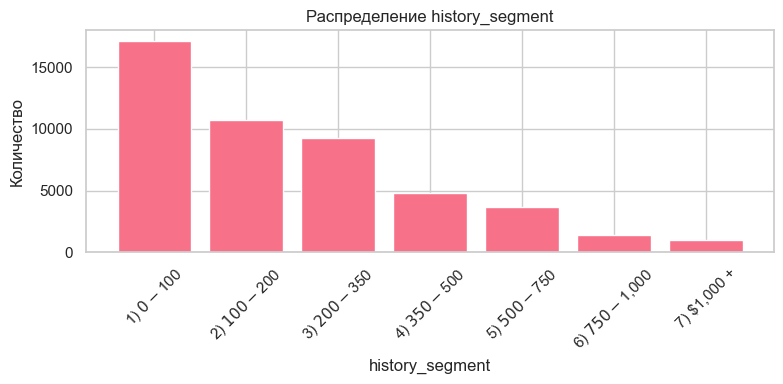

In [143]:
hist_counts = (
    df['history_segment']
    .value_counts(dropna=False)
    .rename_axis('history_segment')
    .reset_index(name='count')
)

# Построение диаграммы
plt.figure(figsize=(8,4))
plt.bar(hist_counts['history_segment'].astype(str), hist_counts['count'])
plt.title('Распределение history_segment')
plt.xlabel('history_segment')
plt.ylabel('Количество')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Подсчёт количества значений в колонке 'visit'
df['visit'].value_counts(dropna=False)
df['visit'].value_counts(dropna=False).rename_axis('visit').reset_index(name='count') 


,visit,count
0,0,40952
1,1,7048


   visit  count
0      0  40952
1      1   7048


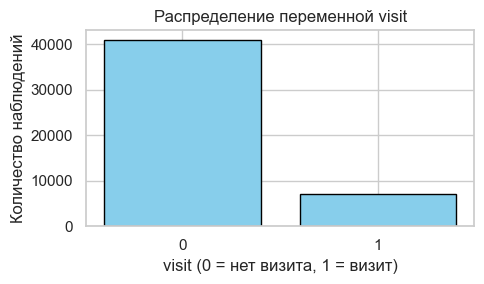

In [144]:
visit_counts = (
    df['visit']
    .value_counts(dropna=False)
    .rename_axis('visit')
    .reset_index(name='count')
)

# Просмотр таблицы
print(visit_counts)

# Построение гистограммы
plt.figure(figsize=(5,3))
plt.bar(visit_counts['visit'].astype(str), visit_counts['count'], color='skyblue', edgecolor='black')
plt.title('Распределение переменной visit')
plt.xlabel('visit (0 = нет визита, 1 = визит)')
plt.ylabel('Количество наблюдений')
plt.tight_layout()
plt.show()

/var/folders/tp/h3xwbjzj52g1cjhylcmqhphr0000gn/T/ipykernel_19062/4199398765.py:27: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  elif pd.api.types.is_categorical_dtype(df[column]) or df[column].dtype == 'object' or pd.api.types.is_bool_dtype(df[column]):
/var/folders/tp/h3xwbjzj52g1cjhylcmqhphr0000gn/T/ipykernel_19062/4199398765.py:27: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  elif pd.api.types.is_categorical_dtype(df[column]) or df[column].dtype == 'object' or pd.api.types.is_bool_dtype(df[column]):
/var/folders/tp/h3xwbjzj52g1cjhylcmqhphr0000gn/T/ipykernel_19062/4199398765.py:27: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  elif pd.api.types.is_categorical_dtype(df[column]) o

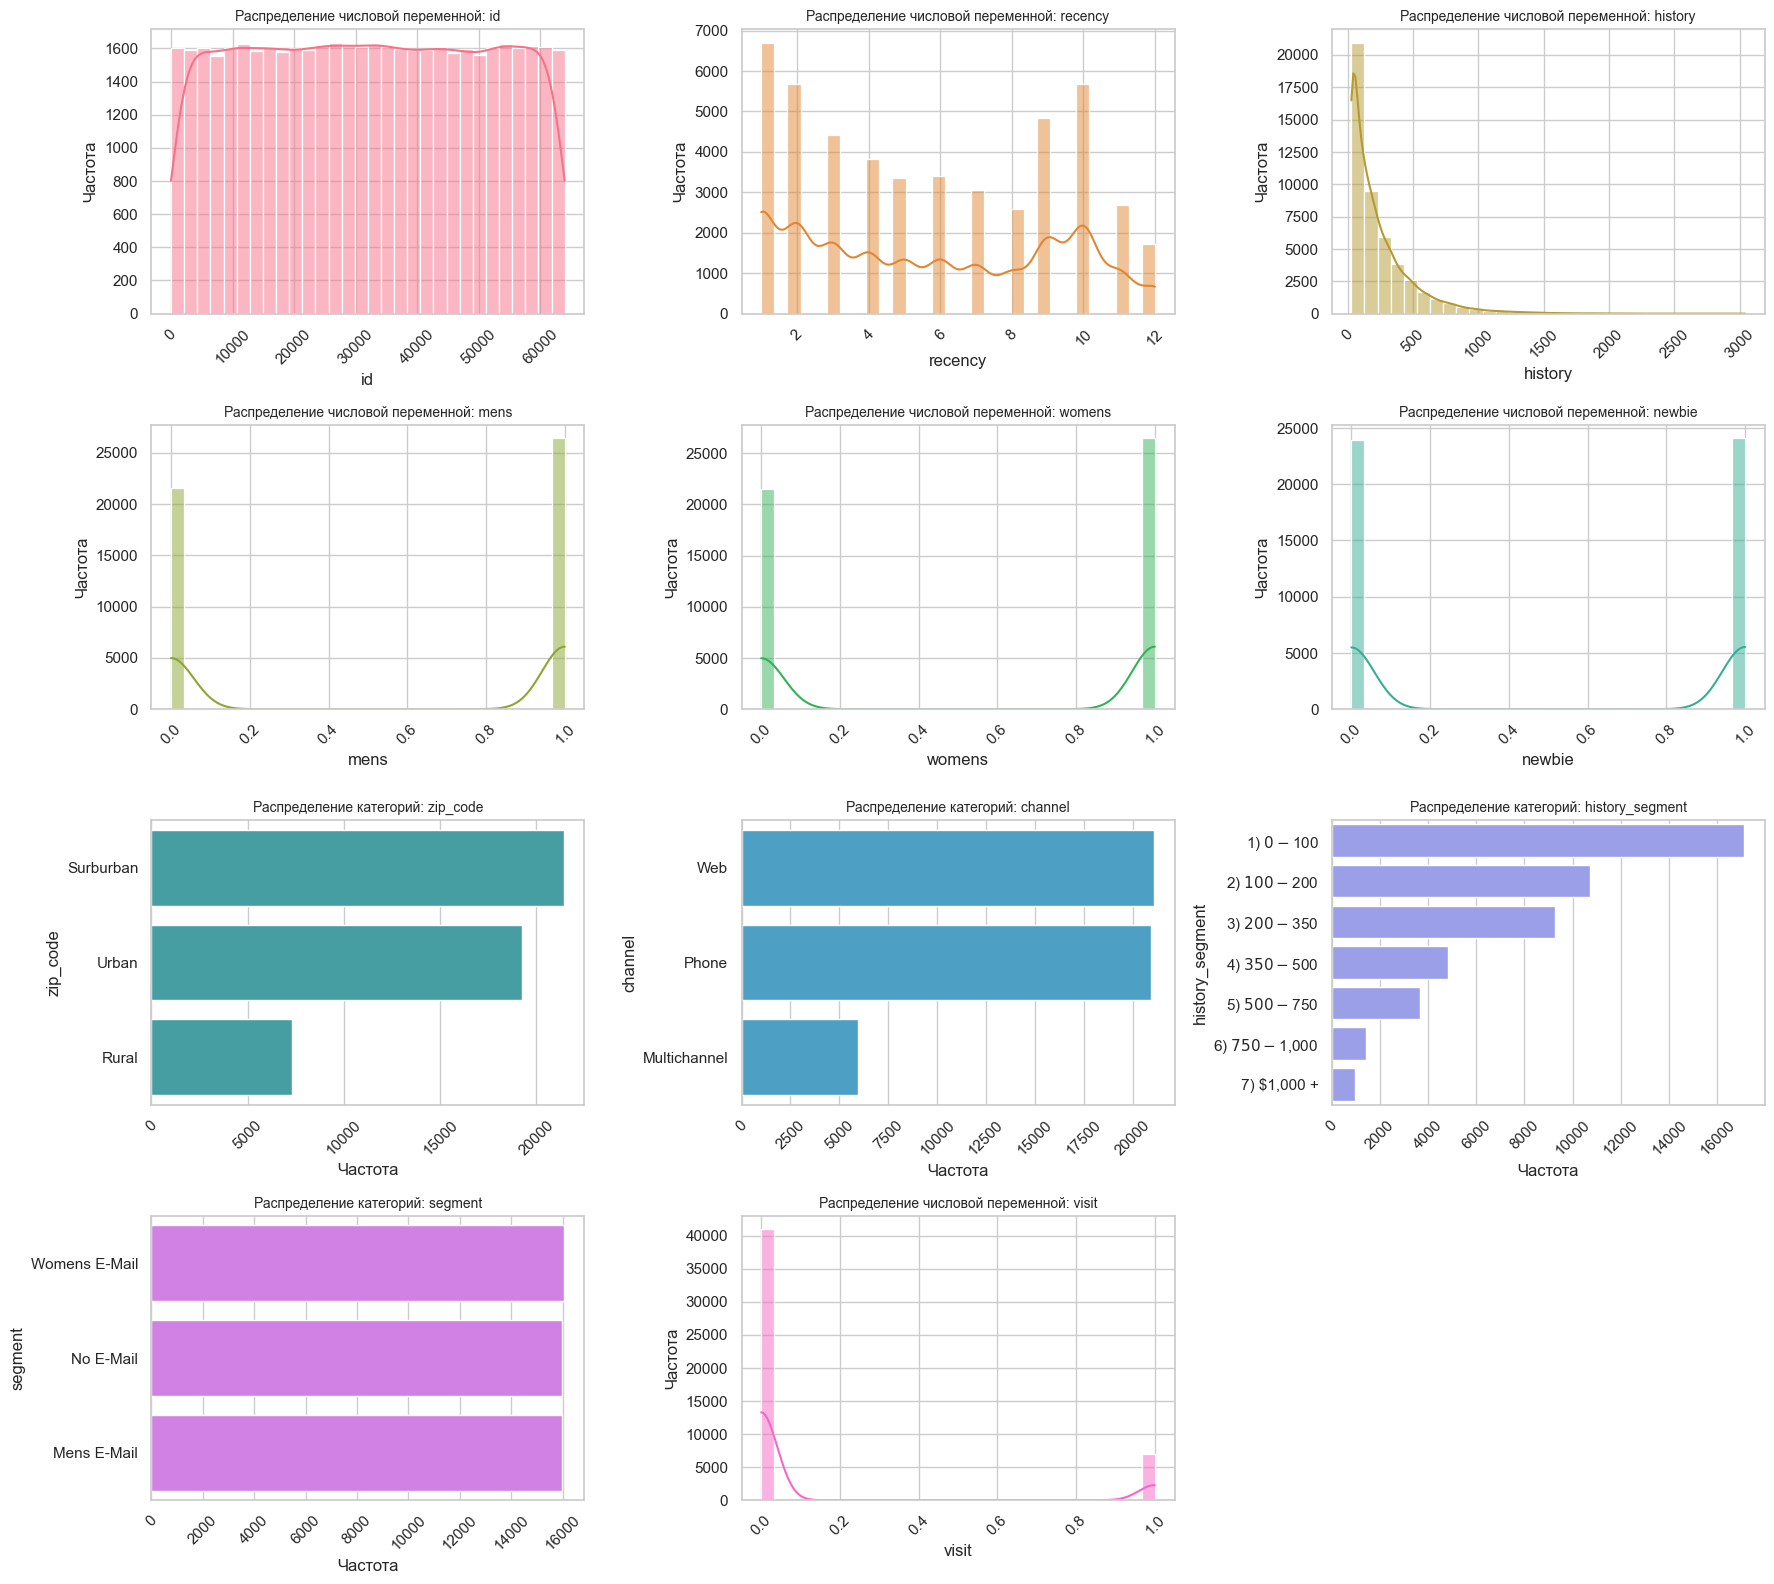

In [148]:
# Рисуем ВСЕ переменные на одном большом холсте (сетка подграфиков)
import math
import numpy as np

cols = df.columns.tolist()
n = len(cols)
# Задаём число колонок в сетке (подберите, если хотите другое)
ncols = 3 if n > 3 else n
nrows = math.ceil(n / ncols)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 6, nrows * 4))
axes = np.array(axes).reshape(-1)

# Палитра строго по количеству колонок (как вы просили)
palette = sns.color_palette("husl", len(cols))

for i, column in enumerate(cols):
    ax = axes[i]
    try:
        # Числовые переменные
        if pd.api.types.is_numeric_dtype(df[column]):
            sns.histplot(df[column].dropna(), kde=True,
                         color=palette[i % len(palette)], bins=30, ax=ax)
            ax.set_title(f'Распределение числовой переменной: {column}', fontsize=10)
            ax.set_xlabel(column)
            ax.set_ylabel('Частота')
        # Категориальные и булевы
        elif pd.api.types.is_categorical_dtype(df[column]) or df[column].dtype == 'object' or pd.api.types.is_bool_dtype(df[column]):
            vc = df[column].value_counts(dropna=False)
            top_n = 20
            if vc.size > top_n:
                vc = vc.nlargest(top_n)
                title_extra = f' (top {top_n})'
            else:
                title_extra = ''
            # Горизонтальная столбчатая диаграмма чтобы метки не накладывались
            sns.barplot(x=vc.values, y=vc.index.astype(str), color=palette[i % len(palette)], ax=ax)
            ax.set_title(f'Распределение категорий: {column}{title_extra}', fontsize=10)
            ax.set_xlabel('Частота')
            ax.set_ylabel(column)
        else:
            # На случай необычных типов
            ax.text(0.5, 0.5, f'Неподдерживаемый тип: {df[column].dtype}', ha='center')
            ax.set_title(column)
    except Exception as e:
        ax.text(0.5, 0.5, f'Ошибка при построении:\n{str(e)}', ha='center')
        ax.set_title(column)

    # Поворот подписей если нужен
    for label in ax.get_xticklabels():
        label.set_rotation(45)
    for label in ax.get_yticklabels():
        label.set_rotation(0)

# Удаляем лишние пустые оси
for j in range(n, nrows * ncols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

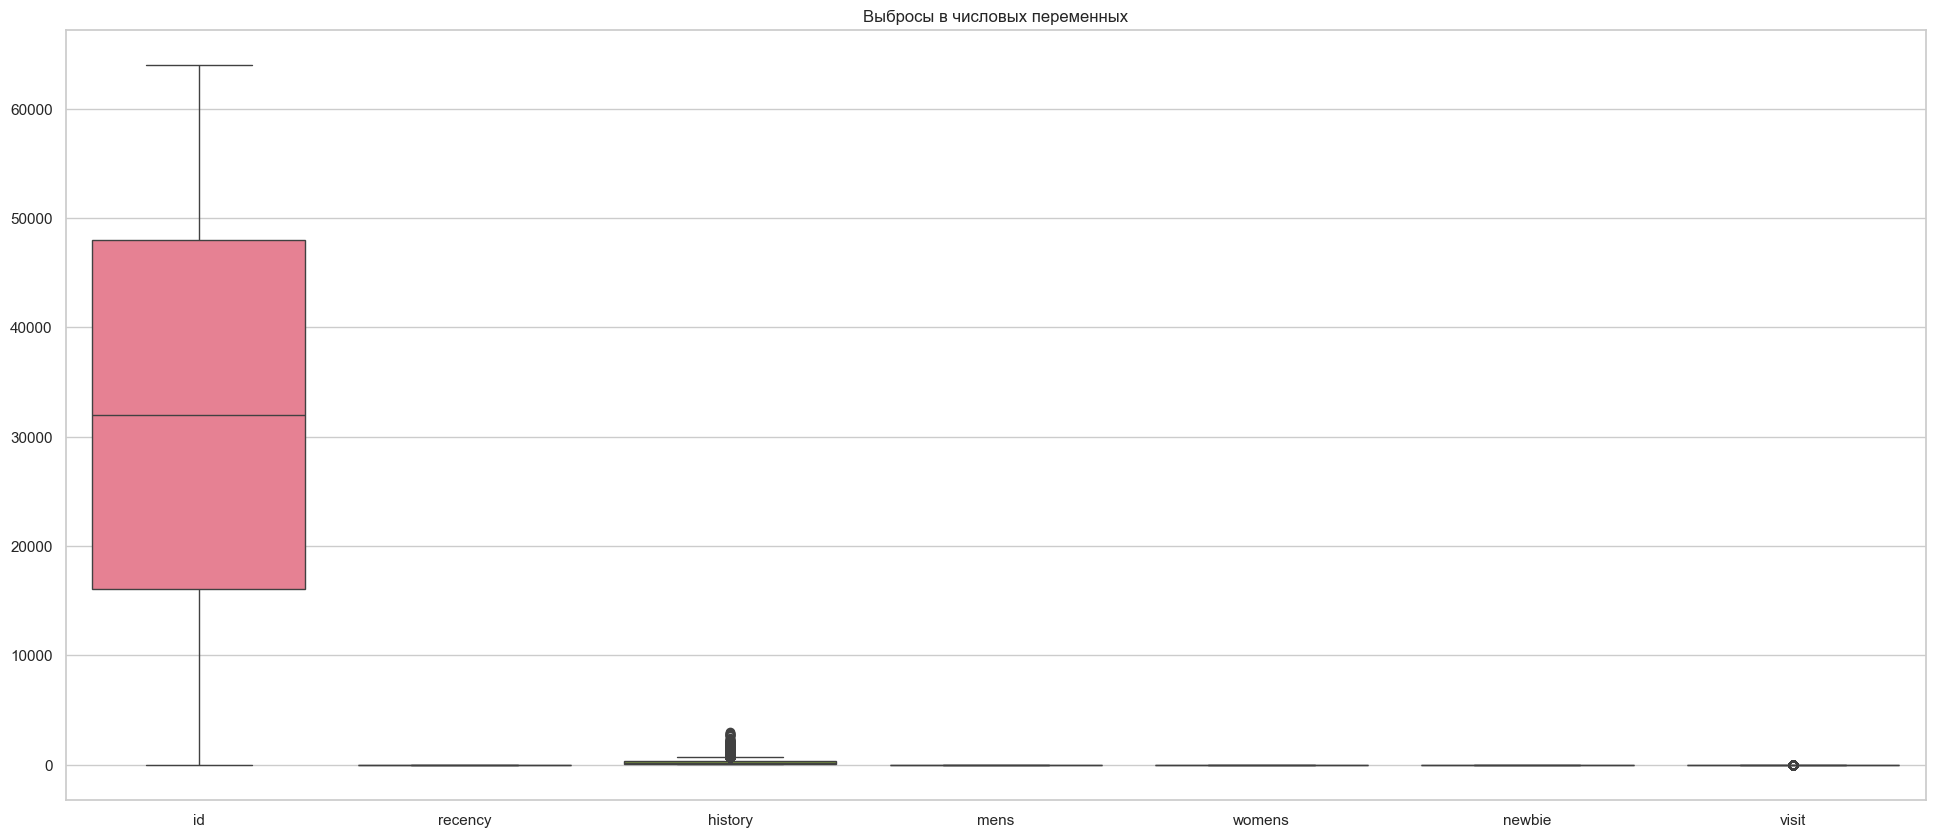

In [149]:
plt.figure(figsize=(24, 10))
sns.boxplot(data=df.select_dtypes(include=['float64', 'int64']))
plt.title("Выбросы в числовых переменных")
plt.show()


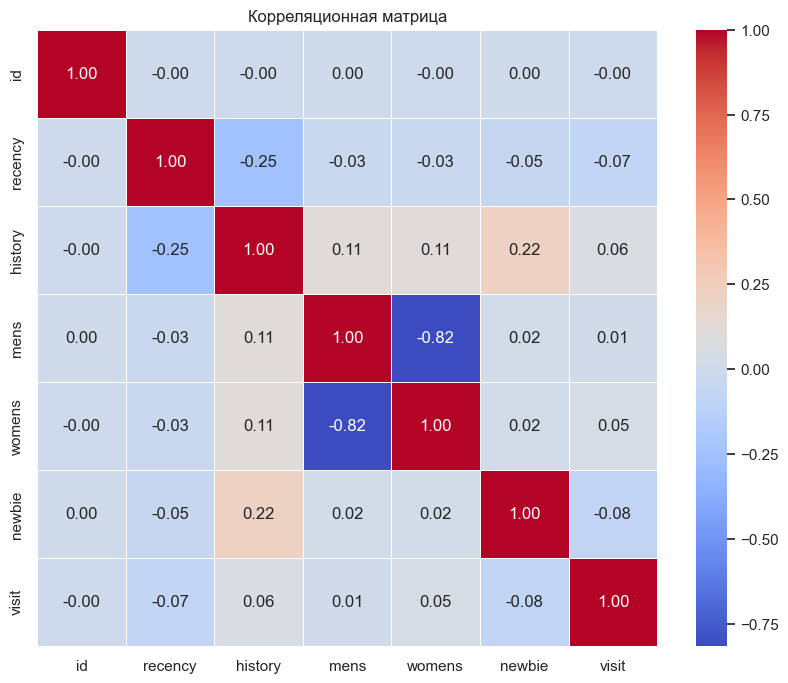

In [150]:
numeric_columns = df.select_dtypes(include=['number'])

# Построение корреляционной матрицы
correlation_matrix = numeric_columns.corr()

# Визуализация корреляционной матрицы
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Корреляционная матрица')
plt.show()

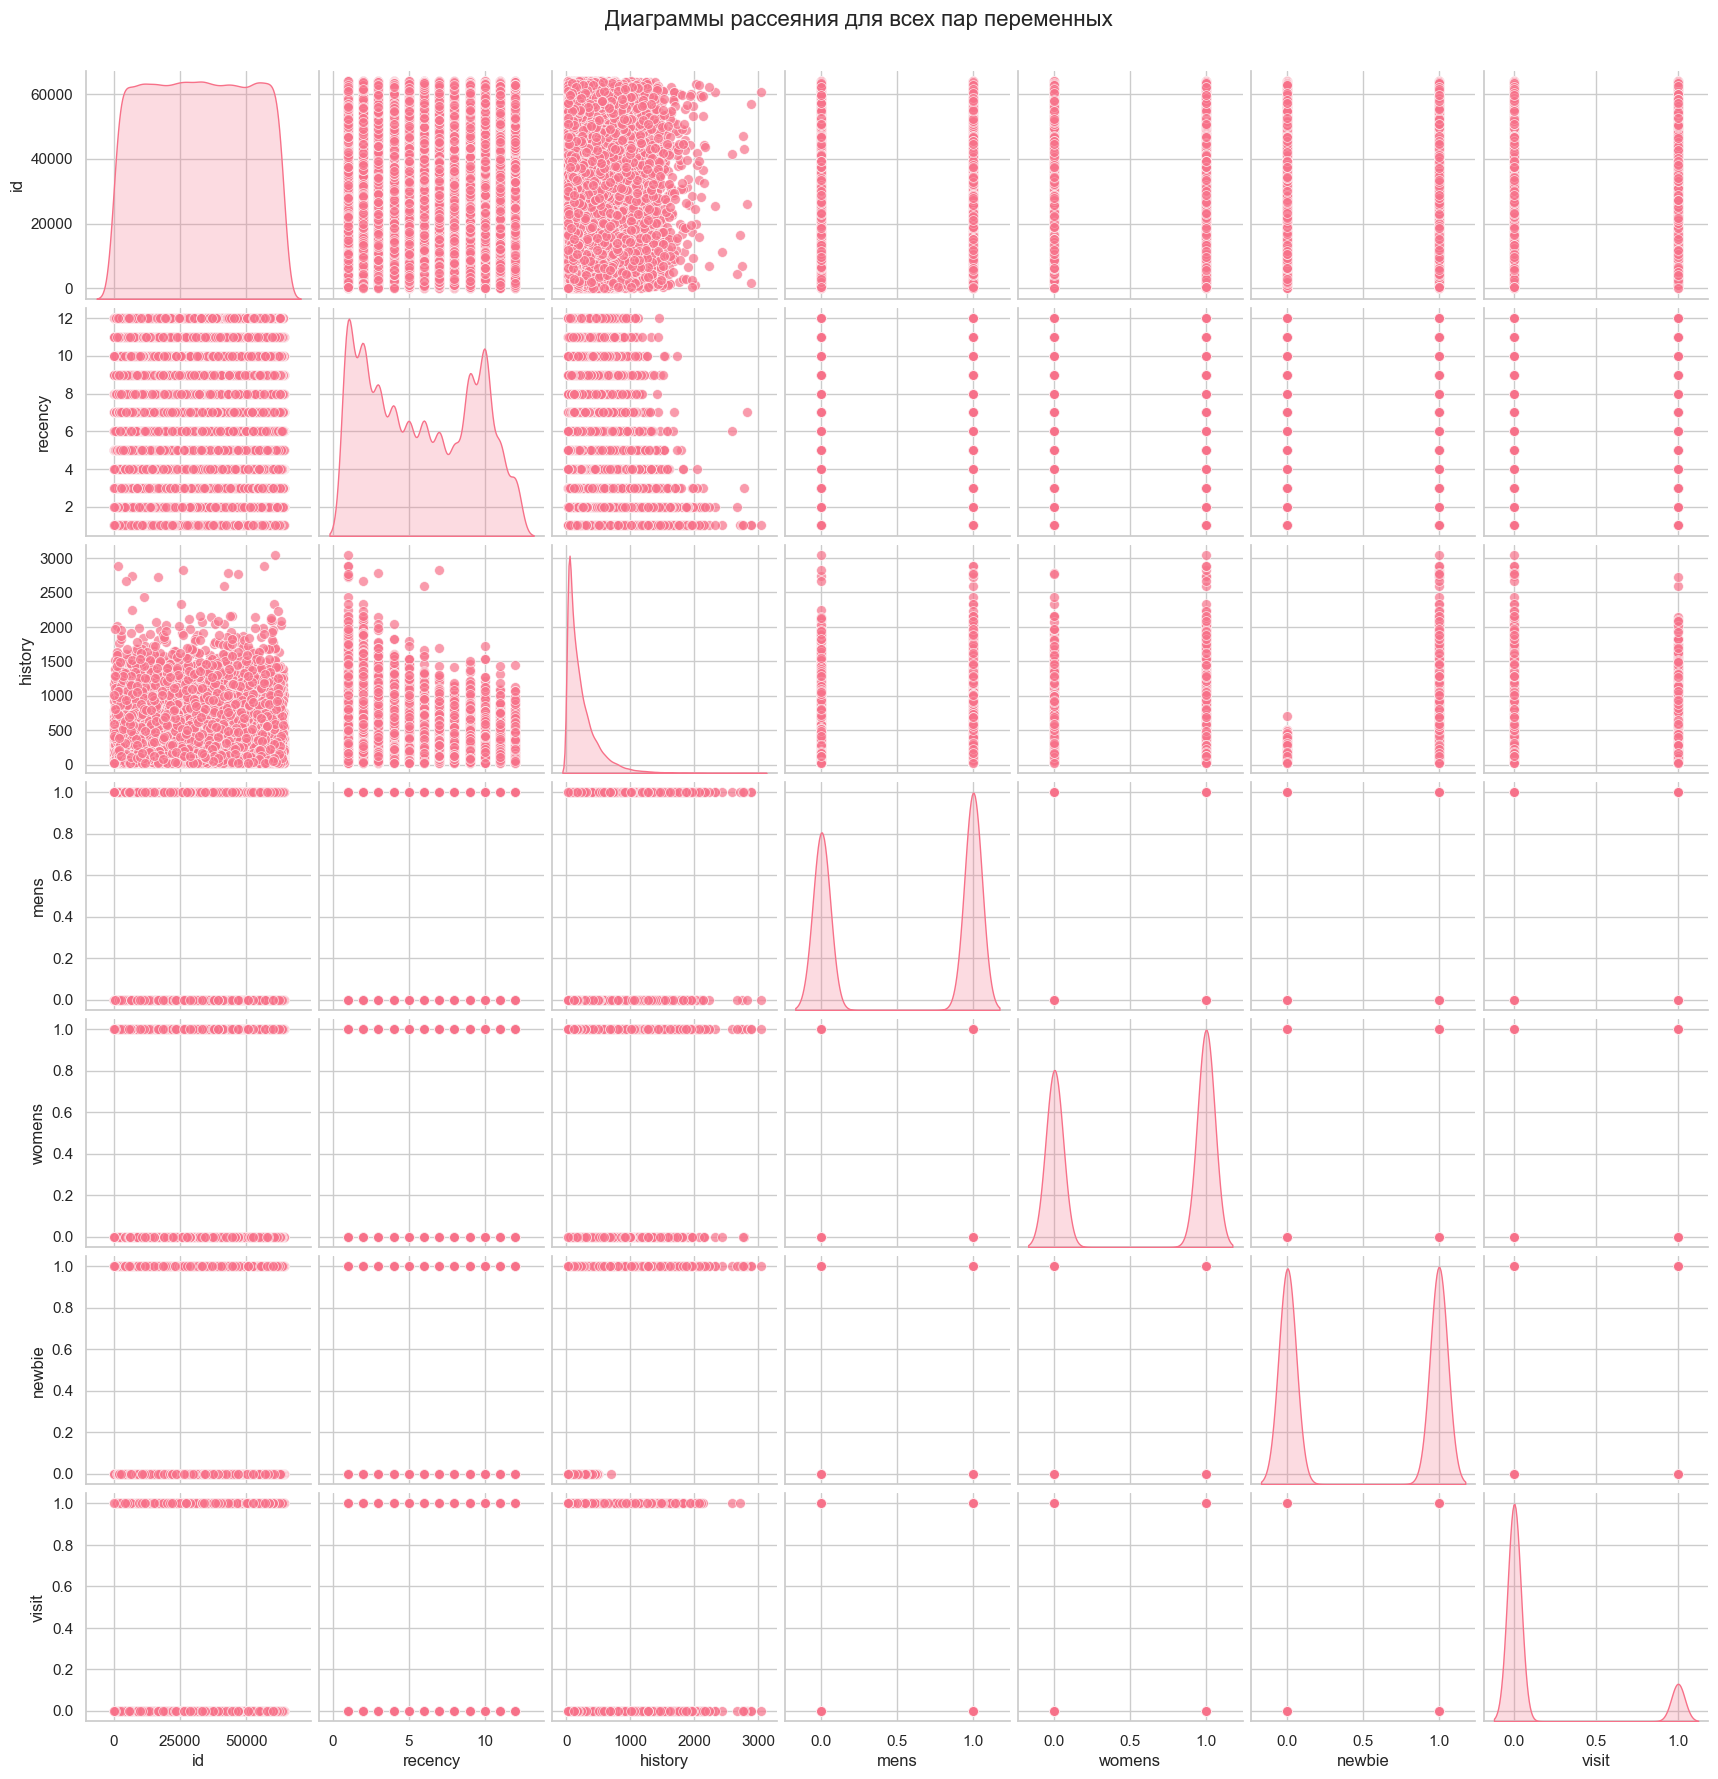

In [151]:
numeric_columns = df.select_dtypes(include=['number'])

# Построение Pairplot
sns.pairplot(numeric_columns, diag_kind='kde', kind='scatter', plot_kws={'alpha': 0.7, 's': 50})
plt.suptitle('Диаграммы рассеяния для всех пар переменных', y=1.02, fontsize=16)
plt.show()

## **Исследование sample_submission данных**

### **Cамый примитивный анализ (this base)**

In [157]:
df = pd.read_csv('amml-competition-2025/sample_submission.csv')
df.head()

,id,p_mens_email,p_womens_email,p_no_email
0,13512,0.333333,0.333333,0.333333
1,900,0.333333,0.333333,0.333333
2,40793,0.333333,0.333333,0.333333
3,56824,0.333333,0.333333,0.333333
4,3244,0.333333,0.333333,0.333333


In [158]:
df.shape

(16000, 4)

In [159]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              16000 non-null  int64  
 1   p_mens_email    16000 non-null  float64
 2   p_womens_email  16000 non-null  float64
 3   p_no_email      16000 non-null  float64
dtypes: float64(3), int64(1)
memory usage: 500.1 KB


In [161]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,16000.0,31948.119500,1.851561e+04,1.000000,15851.750000,32007.500000,48067.000000,63995.000000
p_mens_email,16000.0,0.333333,5.551289e-17,0.333333,0.333333,0.333333,0.333333,0.333333
p_womens_email,16000.0,0.333333,5.551289e-17,0.333333,0.333333,0.333333,0.333333,0.333333
p_no_email,16000.0,0.333333,5.551289e-17,0.333333,0.333333,0.333333,0.333333,0.333333


In [162]:
df.nunique()

id                16000
p_mens_email          1
p_womens_email        1
p_no_email            1
dtype: int64

In [163]:
df[df.duplicated()]

,id,p_mens_email,p_womens_email,p_no_email


## **Исследование тестовых данных**

### **Cамый примитивный анализ (this base)**

In [167]:
df = pd.read_csv('amml-competition-2025/test.csv')
df.head()

,id,recency,history,mens,womens,newbie,zip_code,channel,history_segment
0,13512,8,74.26,0,1,0,Rural,Web,1) $0 - $100
1,900,1,1606.11,1,1,1,Urban,Phone,"7) $1,000 +"
2,40793,10,44.77,1,0,1,Urban,Phone,1) $0 - $100
3,56824,2,216.49,1,1,0,Rural,Web,3) $200 - $350
4,3244,6,985.63,1,1,1,Surburban,Multichannel,"7) $1,000 +"


In [168]:
df.shape

(16000, 9)

In [169]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               16000 non-null  int64  
 1   recency          16000 non-null  int64  
 2   history          16000 non-null  float64
 3   mens             16000 non-null  int64  
 4   womens           16000 non-null  int64  
 5   newbie           16000 non-null  int64  
 6   zip_code         16000 non-null  object 
 7   channel          16000 non-null  object 
 8   history_segment  16000 non-null  object 
dtypes: float64(1), int64(5), object(3)
memory usage: 1.1+ MB


In [170]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,16000.0,31948.119500,18515.607870,1.00,15851.7500,32007.50,48067.0000,63995.00
recency,16000.0,5.757937,3.499658,1.00,2.0000,6.00,9.0000,12.00
history,16000.0,243.417825,257.983596,29.26,64.7075,159.59,328.4375,3333.04
mens,16000.0,0.553438,0.497152,0.00,0.0000,1.00,1.0000,1.00
womens,16000.0,0.545813,0.497912,0.00,0.0000,1.00,1.0000,1.00
newbie,16000.0,0.503437,0.500004,0.00,0.0000,1.00,1.0000,1.00


In [171]:
df.nunique()

id                 16000
recency               12
history            12278
mens                   2
womens                 2
newbie                 2
zip_code               3
channel                3
history_segment        7
dtype: int64

In [172]:
df.isnull().sum()

id                 0
recency            0
history            0
mens               0
womens             0
newbie             0
zip_code           0
channel            0
history_segment    0
dtype: int64

In [173]:
df[df.duplicated()]

,id,recency,history,mens,womens,newbie,zip_code,channel,history_segment


### **Опять картинки, мало ли что-то измениться?**

/var/folders/tp/h3xwbjzj52g1cjhylcmqhphr0000gn/T/ipykernel_19062/4199398765.py:27: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  elif pd.api.types.is_categorical_dtype(df[column]) or df[column].dtype == 'object' or pd.api.types.is_bool_dtype(df[column]):
/var/folders/tp/h3xwbjzj52g1cjhylcmqhphr0000gn/T/ipykernel_19062/4199398765.py:27: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  elif pd.api.types.is_categorical_dtype(df[column]) or df[column].dtype == 'object' or pd.api.types.is_bool_dtype(df[column]):
/var/folders/tp/h3xwbjzj52g1cjhylcmqhphr0000gn/T/ipykernel_19062/4199398765.py:27: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  elif pd.api.types.is_categorical_dtype(df[column]) o

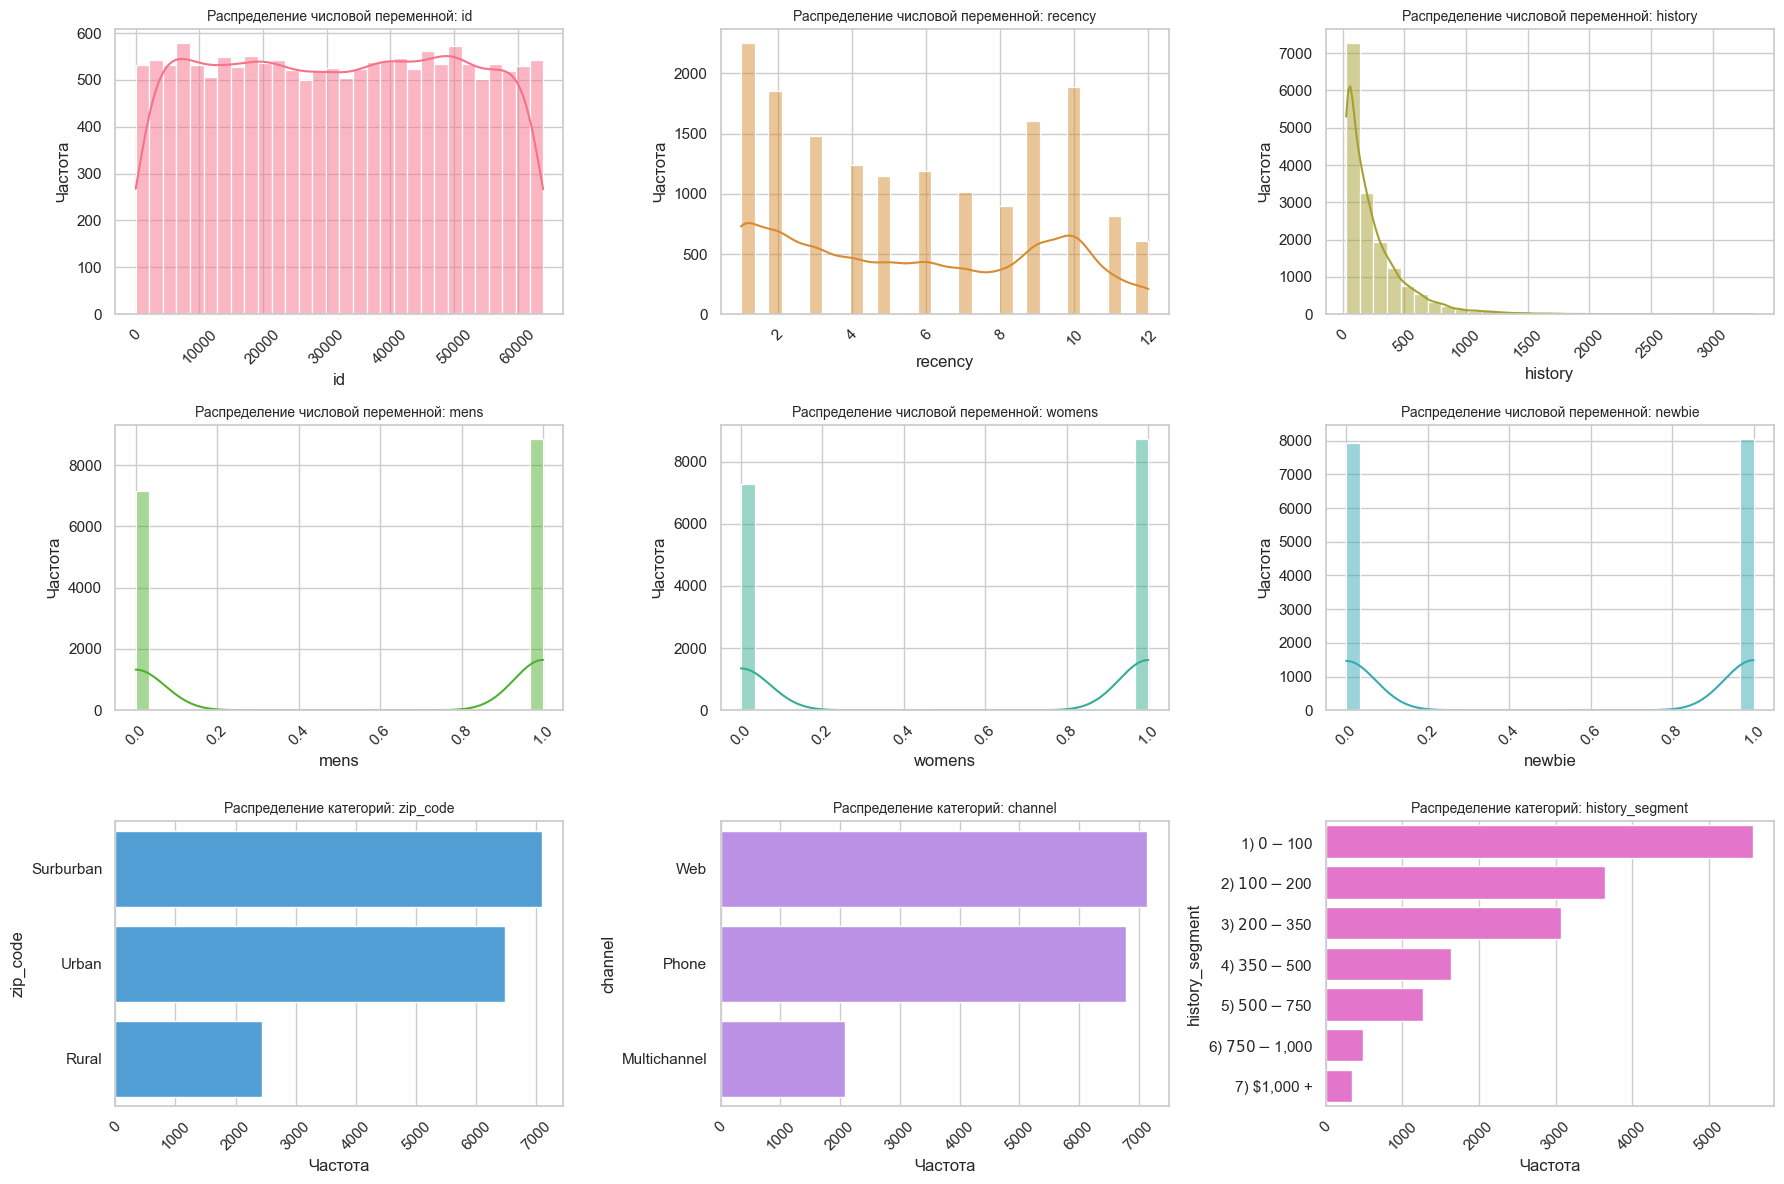

In [174]:
# Рисуем ВСЕ переменные на одном большом холсте (сетка подграфиков)
import math
import numpy as np

cols = df.columns.tolist()
n = len(cols)
# Задаём число колонок в сетке (подберите, если хотите другое)
ncols = 3 if n > 3 else n
nrows = math.ceil(n / ncols)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 6, nrows * 4))
axes = np.array(axes).reshape(-1)

# Палитра строго по количеству колонок (как вы просили)
palette = sns.color_palette("husl", len(cols))

for i, column in enumerate(cols):
    ax = axes[i]
    try:
        # Числовые переменные
        if pd.api.types.is_numeric_dtype(df[column]):
            sns.histplot(df[column].dropna(), kde=True,
                         color=palette[i % len(palette)], bins=30, ax=ax)
            ax.set_title(f'Распределение числовой переменной: {column}', fontsize=10)
            ax.set_xlabel(column)
            ax.set_ylabel('Частота')
        # Категориальные и булевы
        elif pd.api.types.is_categorical_dtype(df[column]) or df[column].dtype == 'object' or pd.api.types.is_bool_dtype(df[column]):
            vc = df[column].value_counts(dropna=False)
            top_n = 20
            if vc.size > top_n:
                vc = vc.nlargest(top_n)
                title_extra = f' (top {top_n})'
            else:
                title_extra = ''
            # Горизонтальная столбчатая диаграмма чтобы метки не накладывались
            sns.barplot(x=vc.values, y=vc.index.astype(str), color=palette[i % len(palette)], ax=ax)
            ax.set_title(f'Распределение категорий: {column}{title_extra}', fontsize=10)
            ax.set_xlabel('Частота')
            ax.set_ylabel(column)
        else:
            # На случай необычных типов
            ax.text(0.5, 0.5, f'Неподдерживаемый тип: {df[column].dtype}', ha='center')
            ax.set_title(column)
    except Exception as e:
        ax.text(0.5, 0.5, f'Ошибка при построении:\n{str(e)}', ha='center')
        ax.set_title(column)

    # Поворот подписей если нужен
    for label in ax.get_xticklabels():
        label.set_rotation(45)
    for label in ax.get_yticklabels():
        label.set_rotation(0)

# Удаляем лишние пустые оси
for j in range(n, nrows * ncols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

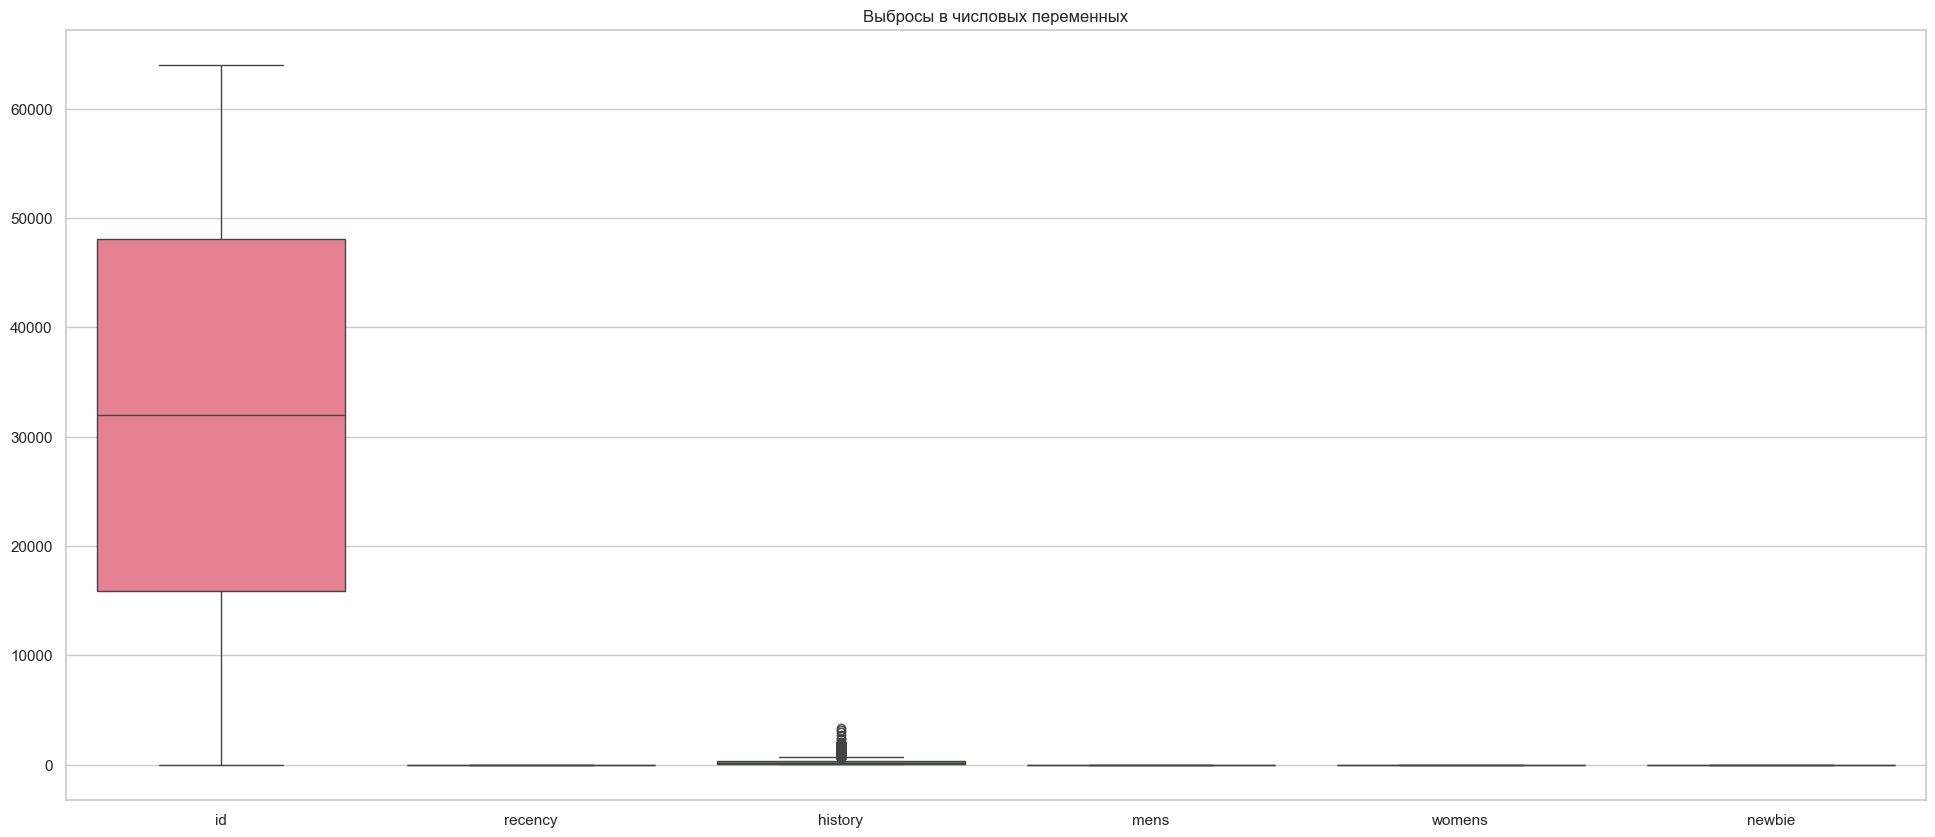

In [175]:
plt.figure(figsize=(24, 10))
sns.boxplot(data=df.select_dtypes(include=['float64', 'int64']))
plt.title("Выбросы в числовых переменных")
plt.show()


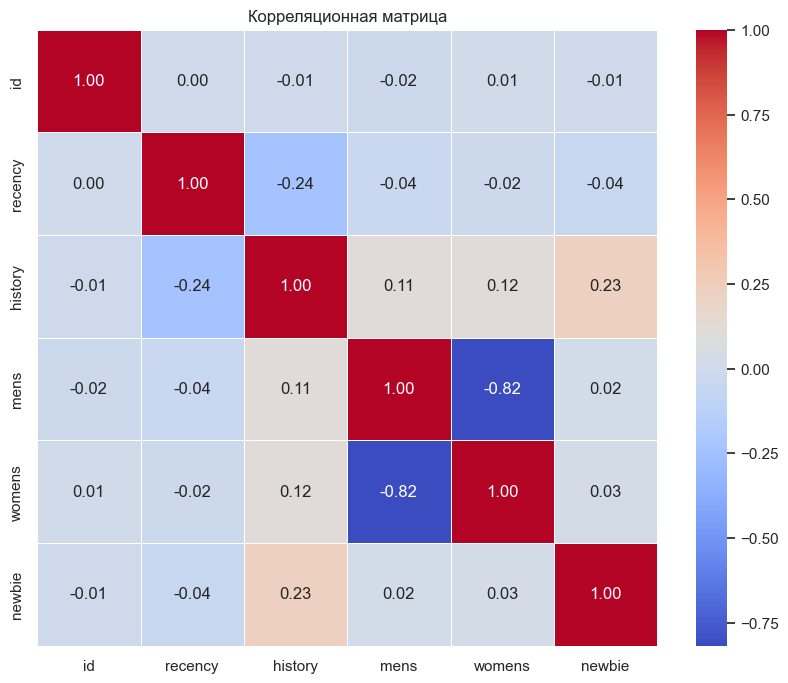

In [176]:
numeric_columns = df.select_dtypes(include=['number'])

# Построение корреляционной матрицы
correlation_matrix = numeric_columns.corr()

# Визуализация корреляционной матрицы
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Корреляционная матрица')
plt.show()

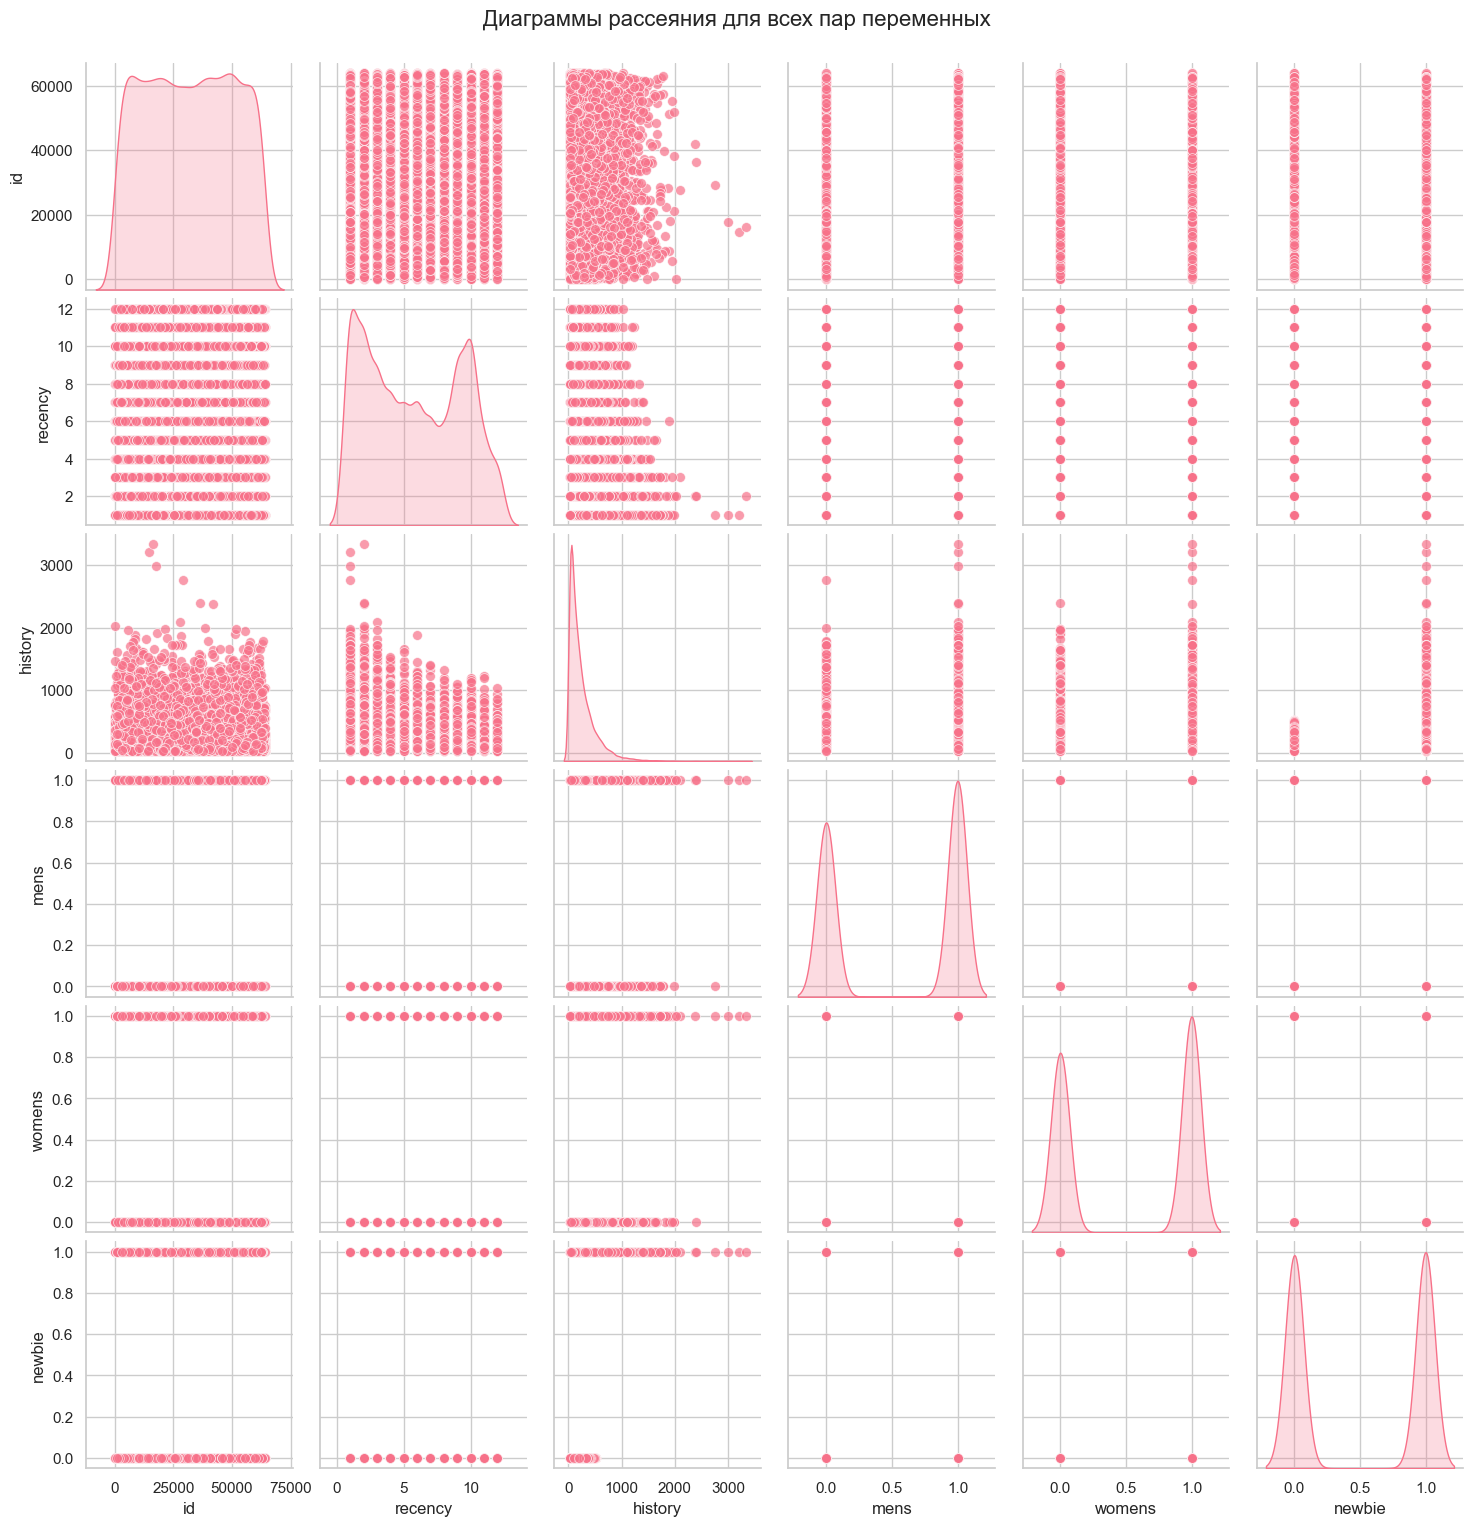

In [177]:
numeric_columns = df.select_dtypes(include=['number'])

# Построение Pairplot
sns.pairplot(numeric_columns, diag_kind='kde', kind='scatter', plot_kws={'alpha': 0.7, 's': 50})
plt.suptitle('Диаграммы рассеяния для всех пар переменных', y=1.02, fontsize=16)
plt.show()

## **Выводы**

## **Выводы**

**🔍 **Ключевые insights из EDA (48k строк, 0% пропусков/дубликатов)**:
- **Target `visit`**: бинарный, **имбаланс 14.7%** (mean=0.147) → **class_weight='balanced' / SMOTE**.
- **`history`**: **skew++ (29-3041$)** → **log1p(history)** must! ↑ corr с visit.
- **`mens/womens` (~55% 1)**: **персонализация!** mens=1 → ↑ P(Mens Email); аналогично womens.
- **`recency` (1-12 дней)**: ↓ visit при ↑ → **binning (fresh/medium/stale)**.
- **Cats**: zip_code (3), channel (3), history_segment (7) → **OneHot**.
- **Pairplot**: history ↑ visit; **low corr** между фичами (no multicollinearity).

**⚠️ **КРИТИЧНО для RL-бандитов (SNIPS метрика)**:
| Что **НЕ** | Почему? | Fix |
|------------|---------|-----|
| **segment как фичу** | Это **treatment** (action)! Нет в test. | **DROP!** |
| **Обычную классификацию** | **Bias от logging policy** (uniform 1/3). | **Per-arm модели** → **π(a\|x) = softmax(Q(a,x))** |
| **Leakage** | Groupby по segment OK **только для baseline**. | **Val: GroupShuffleSplit по id** |

**🚀 **Быстрый baseline (LB top-10)**: RF/XGB **по arm** (Mens/Womens/No) → predict_proba[:,1] → **normalize**.  
**Ожид. скор**: Static ~0.2; Per-arm ~0.5+ → **Tune на SNIPS val**!  
**TODO**: `df.groupby('segment')['visit'].mean()` → best static. **GO!**

## **Кластеризация, а почему бы и нет**